## Data Exploration 1
This is an assignment for my thinkful data science course - "Data Cleaning 2"
Raj Prasad
May 2019


[html version](https://daddyprasad5.github.io/Data_Exploration_1.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/Data_Exploration_1.ipynb) - with all the code exposed in an interactive notebook

In [1]:
#imports
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.stats.mstats import winsorize

%matplotlib inline

In [2]:
#data load
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

raw_used_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
#fill the missing values

used_df = raw_used_df.copy()

#interpolate missing values, as possible

col_list = ['ENROLL', 'TOTAL_REVENUE',
       'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE',
       'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE',
       'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE']

#add a key and change sort order to the most logical sequence 
# for interpolation: first by state and  then by year
used_df["new_pk"] = used_df.STATE + used_df.YEAR.map(str)
used_df.sort_values(by="new_pk", inplace=True)

for col in col_list:
    used_df.loc[:, col].interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
    
#fill with typical proportion of related field for a few remaining NaNs
def fill_with_relative_proportion(df, from_col, to_col): 
    """Fills NaNs in the given dataframe to_col with the median to/from proportion 
    (seen in non-nan columns) multipled by the from_col value"""
    
    not_null_df = used_df.loc[used_df[to_col].notnull()]
    ratios = not_null_df[to_col] / df[from_col] 
    ratio = ratios.median()

    for i, row in used_df.iterrows():
        if np.isnan(row[to_col]): 
            from_value = used_df.get_value(i, from_col)
            used_df.set_value(i, to_col, from_value * ratio)
            
fill_with_relative_proportion(used_df, "AVG_READING_4_SCORE", "AVG_READING_8_SCORE")
fill_with_relative_proportion(used_df, "GRADES_ALL_G", "ENROLL")
fill_with_relative_proportion(used_df, "TOTAL_EXPENDITURE", "OTHER_EXPENDITURE")

#affirm that there are no more NaNs
# n = len(used_df)
# cols = used_df.columns
# num_null = [len(used_df[used_df[col].isnull()]) / n for col in used_df]
# pd.DataFrame([cols, num_null]).transpose()

In [4]:
#raw_used_df["YEAR"].value_counts()
used_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,new_pk
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN,ALABAMA1992
52,1993_ALABAMA,ALABAMA,1993,727716.0,2827391.0,331409.0,1729295.0,766687.0,2833433.0,1564558.0,...,60004.0,39900.0,470775.0,198651.0,677690.0,209.157650,253.289358,208.702830,NaN,ALABAMA1993
104,1994_ALABAMA,ALABAMA,1994,730004.0,2970223.0,331823.0,1850894.0,787506.0,3103266.0,1697593.0,...,59165.0,41730.0,468472.0,201285.0,678808.0,209.987425,254.391193,209.442142,NaN,ALABAMA1994
157,1995_ALABAMA,ALABAMA,1995,727480.0,3367437.0,328957.0,2161366.0,877114.0,3353363.0,1851700.0,...,59914.0,40981.0,470246.0,206840.0,686410.0,210.817199,255.493028,210.181455,NaN,ALABAMA1995
209,1996_ALABAMA,ALABAMA,1996,735912.0,3365113.0,334858.0,2138717.0,891538.0,3572283.0,1987018.0,...,58305.0,42510.0,469370.0,207980.0,686983.0,211.646974,256.594863,210.920767,260.276441,ALABAMA1996


In [5]:
used_df.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
count,1492.000000,1.491000e+03,1.492000e+03,1.492000e+03,1.492000e+03,1.492000e+03,1.492000e+03,1.492000e+03,1.492000e+03,1.491000e+03,...,1492.000000,1492.000000,1492.000000,1.492000e+03,1.492000e+03,1.492000e+03,1492.000000,1492.000000,1492.000000,1488.000000
mean,2004.433646,9.375013e+05,9.464090e+06,7.726970e+05,4.376884e+06,4.314509e+06,9.569077e+06,5.012518e+06,2.770895e+06,4.390856e+05,...,63450.567359,63018.239946,53341.505027,5.101332e+05,2.423717e+05,8.078340e+05,232.232119,276.790271,217.992209,263.365529
std,7.393983,1.030836e+06,1.171655e+07,1.091563e+06,5.475375e+06,5.586724e+06,1.194041e+07,6.446963e+06,3.290115e+06,5.117363e+05,...,78568.306069,77118.938212,66462.009666,6.294368e+05,3.008116e+05,9.596441e+05,10.407623,10.119988,7.852259,5.680165
min,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,1.399630e+05,1.154100e+04,...,633.000000,437.000000,311.000000,4.878000e+03,1.808000e+03,7.254000e+03,187.134670,232.831510,178.557612,236.379102
25%,1998.000000,2.854390e+05,2.422636e+06,2.049810e+05,1.294702e+06,8.678828e+05,2.419590e+06,1.283291e+06,7.336175e+05,1.189842e+05,...,13648.750000,13228.750000,10890.250000,1.097382e+05,5.089525e+04,1.893132e+05,225.823572,270.629663,213.615121,259.833212
50%,2004.000000,6.660190e+05,5.537128e+06,4.316825e+05,2.717148e+06,2.241922e+06,5.627989e+06,2.857330e+06,1.640009e+06,2.893660e+05,...,42933.000000,43019.833333,36429.500000,3.427890e+05,1.612745e+05,5.626110e+05,233.287235,278.396083,219.443318,264.199424
75%,2011.000000,1.117970e+06,1.158220e+07,8.671702e+05,5.460500e+06,5.119936e+06,1.140934e+07,5.909163e+06,3.457968e+06,5.485520e+05,...,75187.916667,75093.500000,67070.000000,6.062042e+05,2.892260e+05,9.515560e+05,240.381157,283.935228,223.524846,267.284657
max,2017.000000,6.307022e+06,8.921726e+07,9.990221e+06,5.090457e+07,3.610526e+07,8.532013e+07,4.396452e+07,2.605802e+07,3.995951e+06,...,493415.000000,500143.000000,498403.000000,3.929869e+06,2.013687e+06,5.944746e+06,253.420961,300.568235,236.773867,280.499130


### 1. Derive the descriptive statistics of the data and discuss the points that you think remarkable.

**Observations:** 
* N = 1492
* Number of states is 80.  It includes protectorates and some others beyond the 50 real states. 
* There are four types of variables: (1) categorical labels (year, state and a concatenation to make the primary key); (2) Continuous State & local budget data (revenue, expenses, instructional expenses, etc.); (3) Continuous Population Data (total and by grade); (4) Reading and math test score averages for 4th and 8th grade.
* The data is for years 1992-2017 (25 years)
* All of the $ figures are left skewed with a hump in the middle
* All of the population data is left skewed
* All of the test data is normal-like.

In [6]:
used_df.describe(include=['O'])

,PRIMARY_KEY,STATE,new_pk
count,1492,1492,1492
unique,1487,80,1487
top,2008_VIRGINIA,DISTRICT_OF_COLUMBIA,VIRGINIA2008
freq,3,29,3


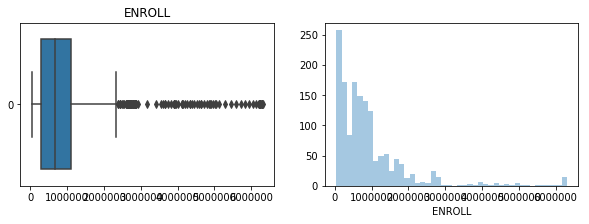

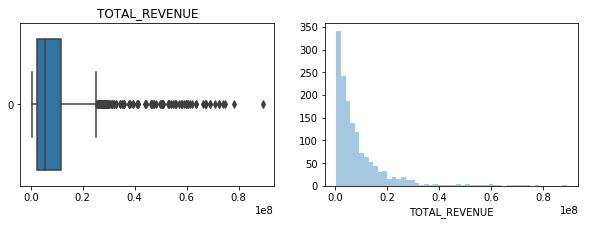

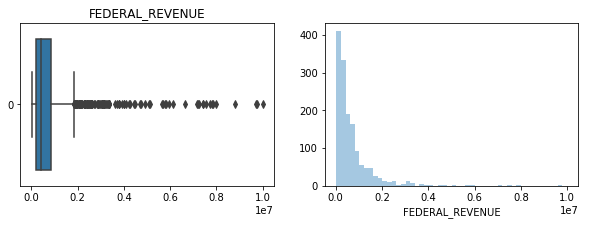

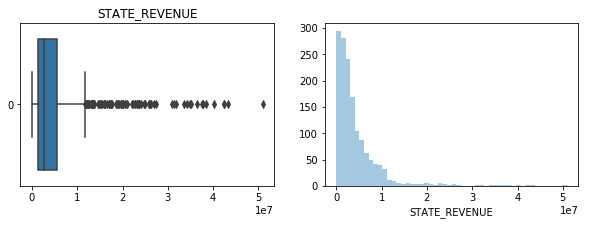

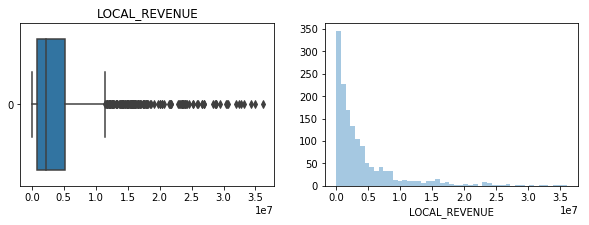

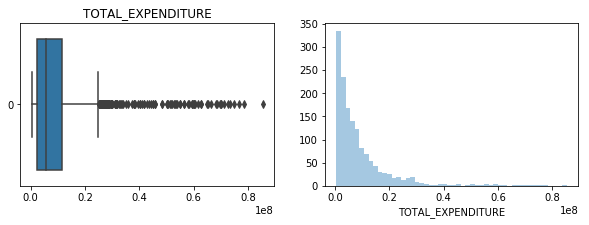

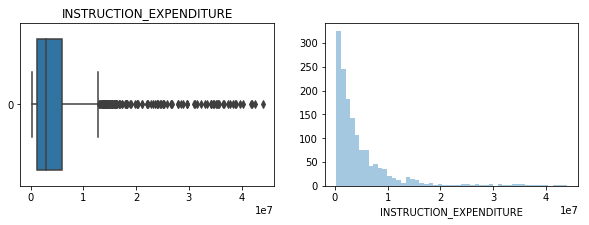

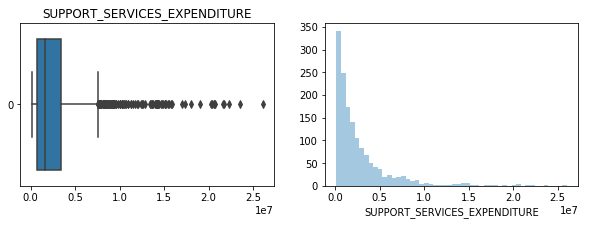

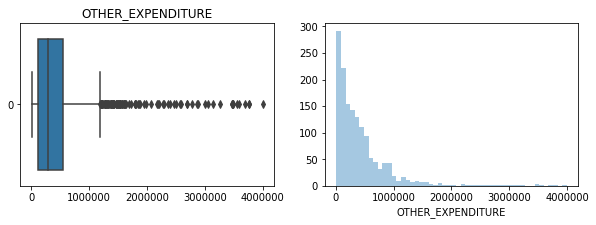

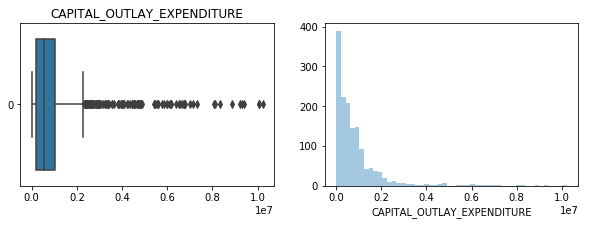

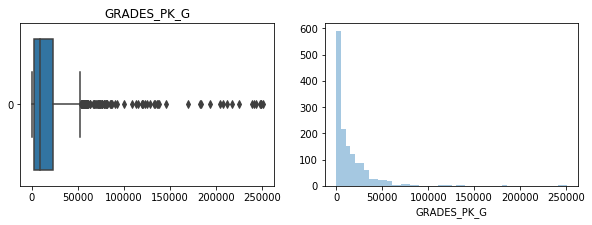

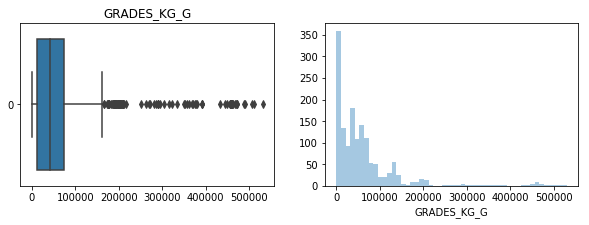

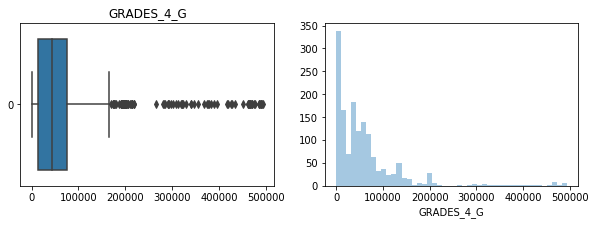

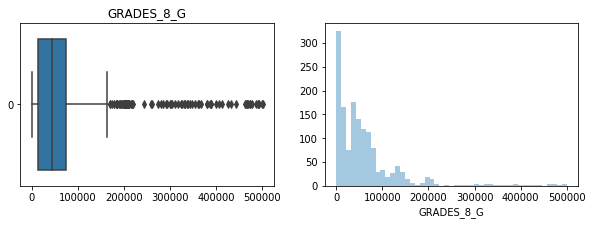

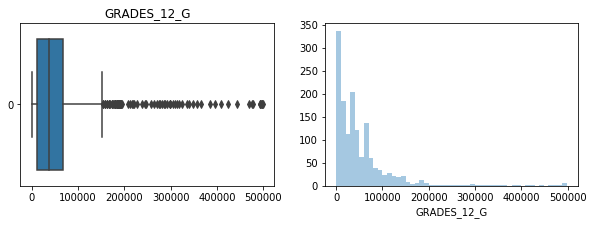

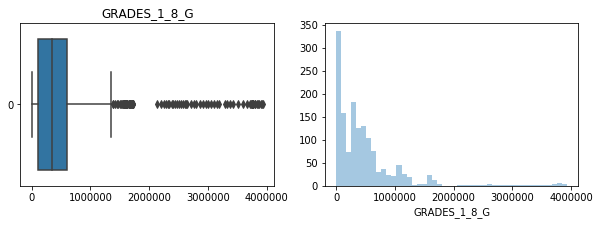

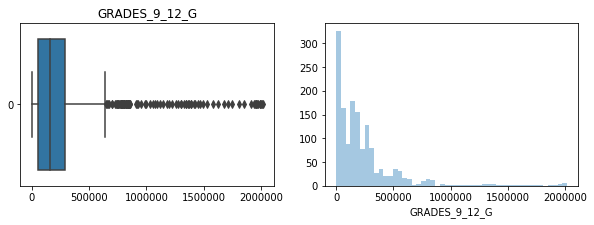

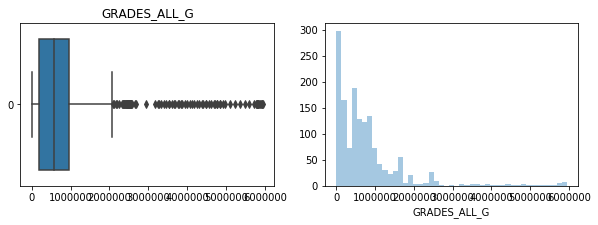

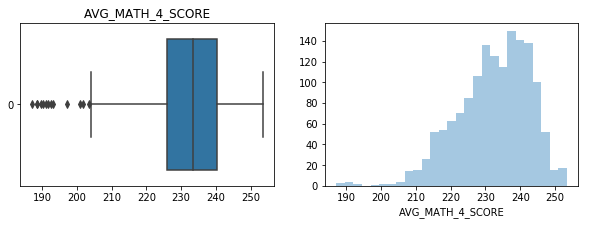

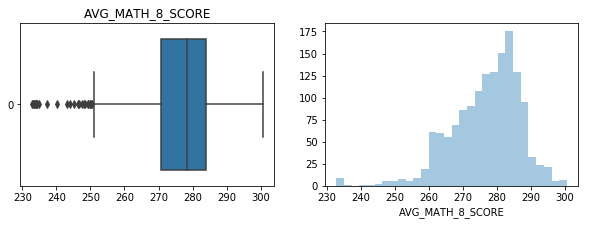

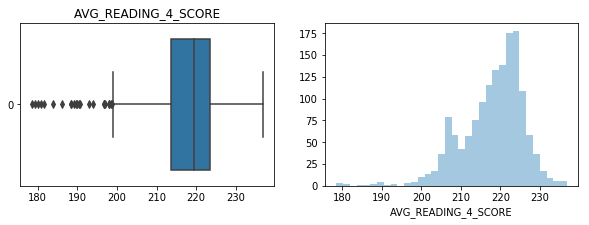

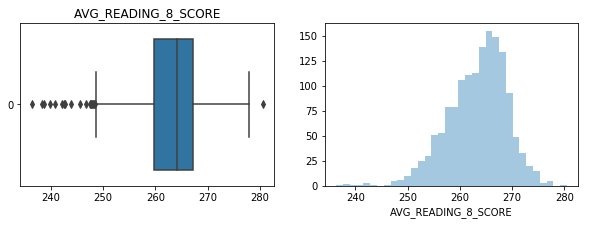

In [7]:
col_list = ['ENROLL', 'TOTAL_REVENUE',
       'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE',
       'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE',
       'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE'] 

for col in col_list: 
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    sns.boxplot(data=used_df[col], orient="h")
    plt.title(col)
    plt.subplot(1,2,2)
    sns.distplot(used_df[col], kde=False)
    plt.show()

## 2 . Choose a state (e.g. California) and draw a line graph of its total revenues and total expenditures along the years. How do these two variables evolve during the years? Try to explain the peaks and troughs with some state-wise news and informations around those dates.

*Observations*
* Alabama seems to run a regular defecit in the years covered by the sample, though they are modest 
* 2009 seems to have been a particularly bad year.  Can't find an explanation in some quick google searches. 
* There's something funky happening with my interpolatin of 2017 data - so ignoring that year. 

Text(0.5, 1.0, 'surplus (defecit) by year')

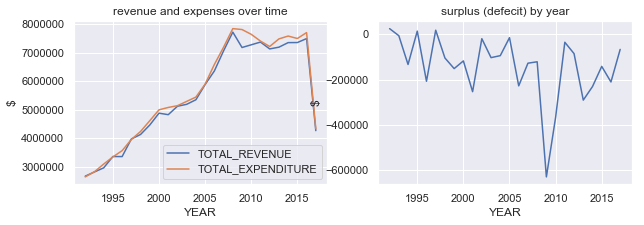

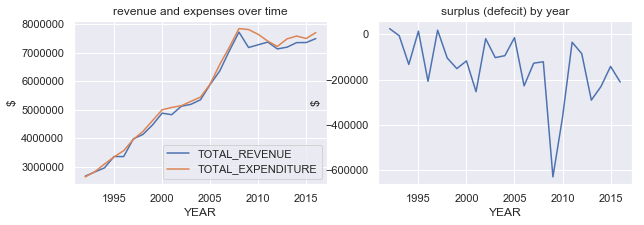

In [8]:
a_state = used_df[used_df.STATE == "ALABAMA"]

sns.set()
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
sns.lineplot(y = "TOTAL_REVENUE", x = "YEAR", data=a_state)
sns.lineplot(y = "TOTAL_EXPENDITURE", x = "YEAR", data=a_state)
plt.legend(["TOTAL_REVENUE", "TOTAL_EXPENDITURE"])
plt.ylabel("$")
plt.title("revenue and expenses over time")

plt.subplot(1,2,2)
sns.lineplot(y = (a_state["TOTAL_REVENUE"] - a_state["TOTAL_EXPENDITURE"]), x = "YEAR", data=a_state)
plt.ylabel("$")
plt.title("surplus (defecit) by year")

b_state = raw_used_df[raw_used_df.STATE == "ALABAMA"]

sns.set()
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
sns.lineplot(y = "TOTAL_REVENUE", x = "YEAR", data=b_state)
sns.lineplot(y = "TOTAL_EXPENDITURE", x = "YEAR", data=b_state)
plt.legend(["TOTAL_REVENUE", "TOTAL_EXPENDITURE"])
plt.ylabel("$")
plt.title("revenue and expenses over time")

plt.subplot(1,2,2)
sns.lineplot(y = (a_state["TOTAL_REVENUE"] - b_state["TOTAL_EXPENDITURE"]), x = "YEAR", data=b_state)
plt.ylabel("$")
plt.title("surplus (defecit) by year")

### 3. In your chosen state, which one of the lessons the students are more successful, math or reading?  

Math

### 4. What are the distributions of the math and reading scores in the sample?
see below

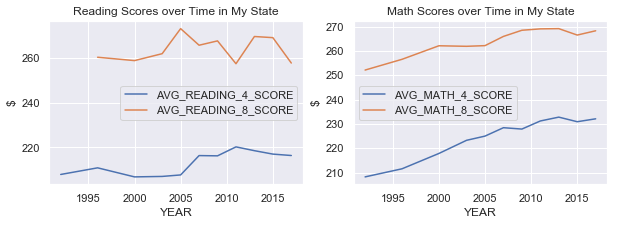

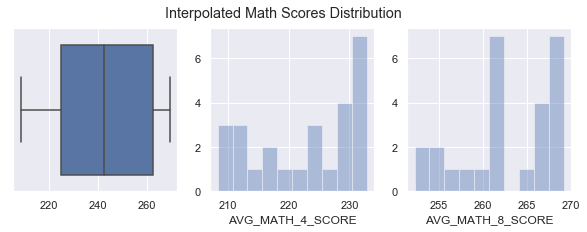

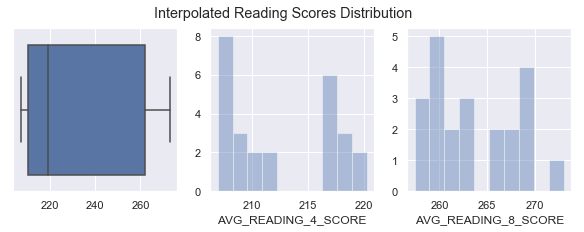

In [43]:
sns.set()
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
sns.lineplot(y = 'AVG_READING_4_SCORE', x = "YEAR", data=b_state)
sns.lineplot(y = 'AVG_READING_8_SCORE', x = "YEAR", data=b_state)
plt.legend(["AVG_READING_4_SCORE", "AVG_READING_8_SCORE"])
plt.ylabel("$")
plt.title("Reading Scores over Time in My State")

plt.subplot(1,2,2)
sns.lineplot(y = 'AVG_MATH_4_SCORE', x = "YEAR", data=b_state)
sns.lineplot(y = 'AVG_MATH_8_SCORE', x = "YEAR", data=b_state)
plt.legend(["AVG_MATH_4_SCORE", "AVG_MATH_8_SCORE"])
plt.ylabel("$")
plt.title("Math Scores over Time in My State")
plt.show()

def math_scores_plots(df, figure_title):
    """creates a set of distribution plots for the given dataframe
    assumes a lot about the dataframe - meant only for this exercise"""
    
    fig = plt.figure(figsize=(10,3))
    fig.suptitle(figure_title)
    plt.subplot(1,3,1)
    sns.boxplot(df[["AVG_MATH_4_SCORE", "AVG_MATH_8_SCORE"]])
    plt.subplot(1,3,2)
    sns.distplot(df["AVG_MATH_4_SCORE"], bins=10, kde=False)
    plt.subplot(1,3,3)
    sns.distplot(df["AVG_MATH_8_SCORE"], bins=10, kde=False)

def reading_scores_plots(df, figure_title):
    """creates a set of distribution plots for the given dataframe
    assumes a lot about the dataframe - meant only for this exercise"""
    
    fig = plt.figure(figsize=(10,3))
    fig.suptitle(figure_title)
    plt.subplot(1,3,1)
    sns.boxplot(df[["AVG_READING_4_SCORE", "AVG_READING_8_SCORE"]])
    plt.subplot(1,3,2)
    sns.distplot(df["AVG_READING_4_SCORE"], bins=10, kde=False)
    plt.subplot(1,3,3)
    sns.distplot(df["AVG_READING_8_SCORE"], bins=10, kde=False)
    
math_scores_plots(a_state, "Interpolated Math Scores Distribution")
reading_scores_plots(a_state, "Interpolated Reading Scores Distribution")


### 5. Notice that there are too many missing values for math and reading scores. Fill out the missing values using mean, median and linear interpolation. Then compare the effects of these techniques on the distributions of the score variables.

The interpolation method distorts the distribution far less.  Both median and mean pull the peak of the distribution higher, and the mean pulls the peak to the right because of the skew of the underlying scores distribution. 

In [45]:
#mean & median fill - using the mean for the state
a_state_2 = raw_used_df[raw_used_df.STATE == "ALABAMA"]
a_st_scores_mean = a_state_2[["YEAR", "AVG_READING_4_SCORE", "AVG_READING_8_SCORE", "AVG_MATH_4_SCORE", "AVG_MATH_8_SCORE"]]
a_st_scores_median = a_state_2[["YEAR", "AVG_READING_4_SCORE", "AVG_READING_8_SCORE", "AVG_MATH_4_SCORE", "AVG_MATH_8_SCORE"]]
fill_list = ["AVG_READING_4_SCORE", "AVG_READING_8_SCORE", "AVG_MATH_4_SCORE", "AVG_MATH_8_SCORE"]

for col in fill_list:
    a_st_scores_mean.loc[:, col].fillna(a_st_scores_mean.loc[:, col].mean(), inplace=True)
    a_st_scores_median.loc[:, col].fillna(a_st_scores_median.loc[:, col].median(), inplace=True)


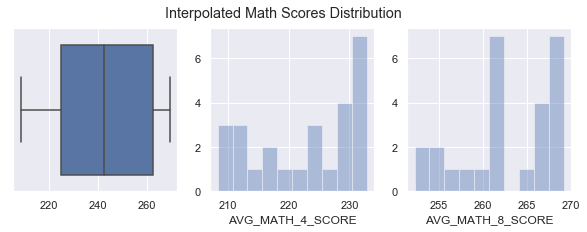

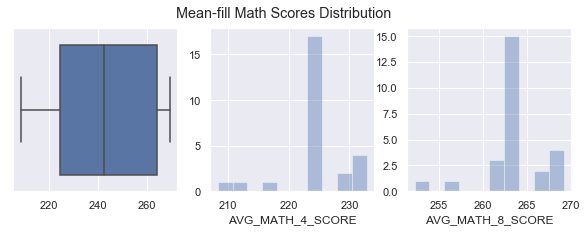

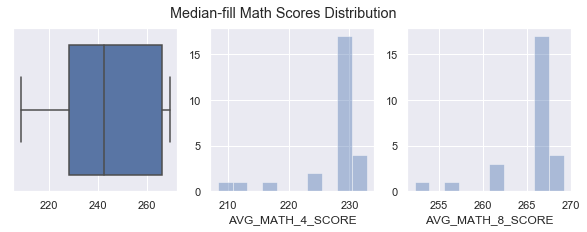

In [49]:
#math scores distributions comparison
math_scores_plots(a_state, "Interpolated Math Scores Distribution")
math_scores_plots(a_st_scores_mean, "Mean-fill Math Scores Distribution")
math_scores_plots(a_st_scores_median, "Median-fill Math Scores Distribution")